## Een clusteralgoritme voor de *Partial Discharges*
Als we een plot maken van de Partial Discharges ziet het er ongeveer zo uit:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [12, 6]

filelist=["1512","2063","2145","2806","2870","2979","2980","3010"]

In [2]:
def findall(string,char):
    arr=np.array([])
    for i in range(len(string)):
        if string[i]==char:
            arr=np.append(arr,[i])
    return arr

In [3]:
def open_file(file):
    lst=np.array(open(file,"r").readlines())
    timearr=np.array([])
    placearr=np.array([])
    chargearr=np.array([])
    for i in range(1,len(lst)):
        if lst[i][19:]!=';;\n':
            fnd=findall(lst[i],";")
            timearr=np.append(timearr,[i])
            placearr=np.append(placearr,[float(lst[i][int((fnd[0]+1)):int(fnd[1])])])
            chargearr=np.append(chargearr,[float(lst[i][int(fnd[1]+1):])])
    return np.vstack((timearr,placearr,chargearr))

In [4]:
def show_scatter(data,count_charges=False,fig="Scatter"):
    maxplace=max(data[1])
    maxtime=max(data[0])
    maxcharge=max(data[2])
    plt.figure(fig)
    plt.axis([0,maxplace,0,maxtime])
    plt.xlabel("Plaats")
    plt.ylabel("Tijd")
    plt.scatter(data[1],data[0],marker="o",s=data[2]*100/maxcharge if count_charges else 1,c="black")

<IPython.core.display.Javascript object>


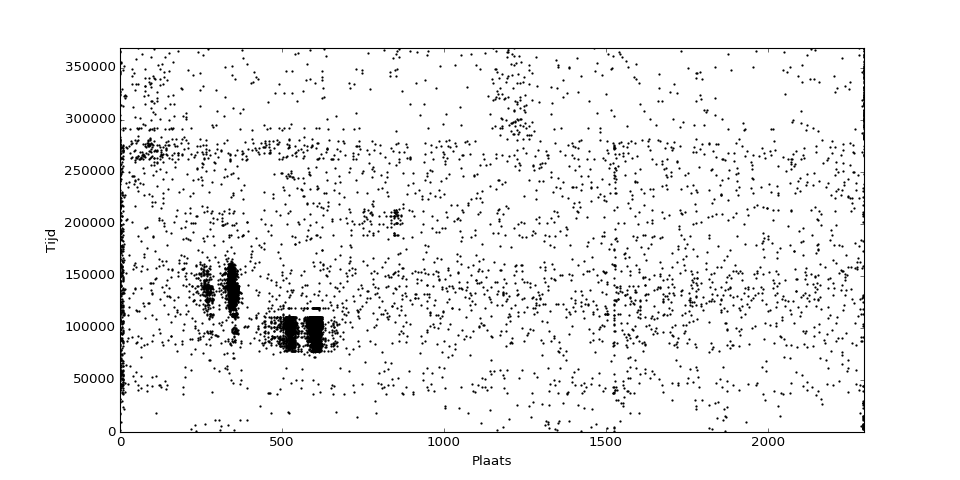

In [61]:
%matplotlib notebook
show_scatter(open_file("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[1]+"-pd.csv"))
plt.show()

We zien dat er in sommige gebieden clusters liggen. Deze clusters zijn gebieden waar relatief veel partial discharges zitten. Om over de verdeling van partial discharges te praten delen we de plot op in een rooster. Vervolgens tellen we hoeveel partial discharges er in een hokje van dat rooster zitten. We kunnen hier een 3D-plot van maken. Hieronder is een deel van de dataset te zien. Elke 20 meter en elke maand is weergegeven met één hokje.

In [6]:
def get_box_x(index,boxnumber,maxplace,data):
    return min(boxnumber-1,int(data[1][index]*boxnumber/maxplace))

In [7]:
def get_box_y(index,boxnumber,maxtime,data):
    return min(boxnumber-1,int(data[0][index]*boxnumber/maxtime))

In [8]:
def make_pdgrid(data,placeinterval,timeinterval):
    maxplace=max(data[1])
    maxtime=max(data[0])
    boxesx=int(maxplace/placeinterval)
    boxesy=int(maxtime/timeinterval)
    grid=np.zeros((boxesx,boxesy))
    datalength=len(data[0])

    for i in range(datalength):
        grid[get_box_x(i,boxesx,maxplace,data),get_box_y(i,boxesy,maxtime,data)]+=1
    return grid

In [9]:
def plot_3d(file,placeinterval=10,timeinterval=60*24*7):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    data=open_file(file)
    
    grid=make_pdgrid(data,placeinterval,timeinterval)
    
    grid=grid[int(len(grid)*0):int(len(grid)*0.5),int(len(grid[0])*0):int(len(grid[0])*0.5)]
    
    xsize=len(grid[1])
    ysize=len(grid)
    
    x=np.array([[i]*xsize for i in range(ysize)]).ravel()
    y=np.array([i for i in range(xsize)]*ysize)
    z=np.zeros(ysize*xsize)
    dx=np.ones(ysize*xsize)
    dy=np.ones(ysize*xsize)
    dz=grid.ravel()

    ax.bar3d(x, y, z,dx,dy,dz)  

<IPython.core.display.Javascript object>


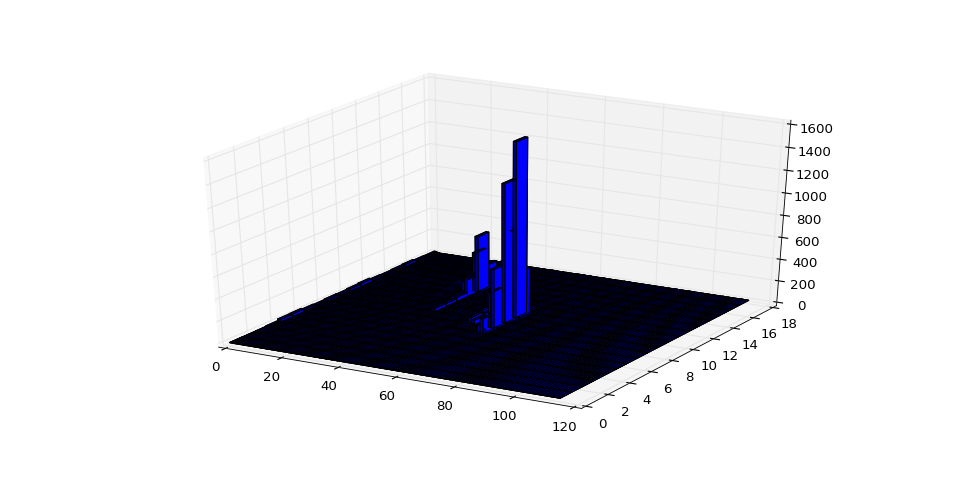

In [60]:
%matplotlib notebook
plot_3d("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[1]+"-pd.csv")
plt.show()

We kunnen de staven sorteren op grootte. Dit levert de volgende plot op. Let er hierbij op dat dit stukje van de grafiek over de 0.5% data gaat met de meeste partial discharges.

In [11]:
def plot_boxes_sorted(file,placeinterval=10,timeinterval=60*24*7):
    data=open_file(file)
    grid=make_pdgrid(data,placeinterval,timeinterval)
    grid=grid.flatten()
    grid=np.sort(grid)
    minval=int(0.995*len(grid))
    grid=grid[minval:]
    plt.xlabel("rangnummer van het (gesorteerde) roosterpunt")
    plt.ylabel("aantal partial discharges in het roosterpunt")
    plt.plot(np.arange(minval,minval+len(grid),1),grid)

<IPython.core.display.Javascript object>


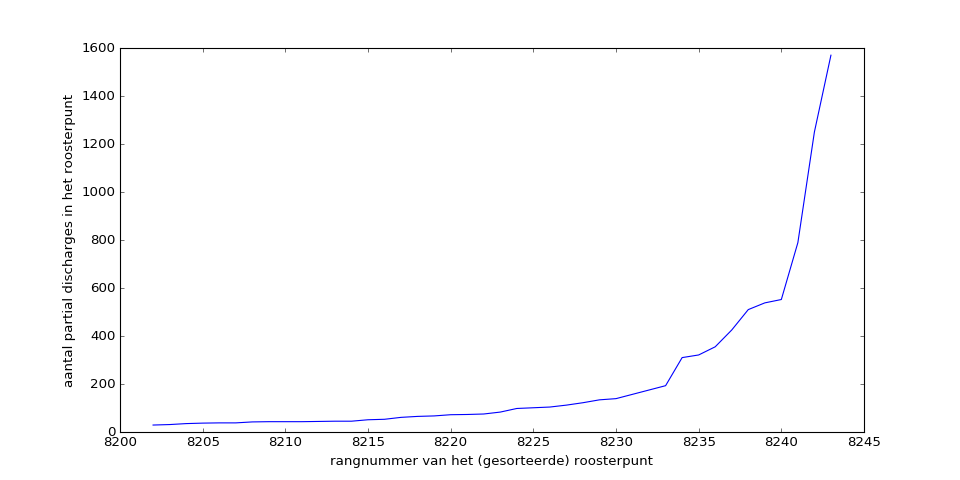

In [59]:
%matplotlib notebook
plot_boxes_sorted("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[1]+"-pd.csv")
plt.show()

Van een andere dataset:

<IPython.core.display.Javascript object>


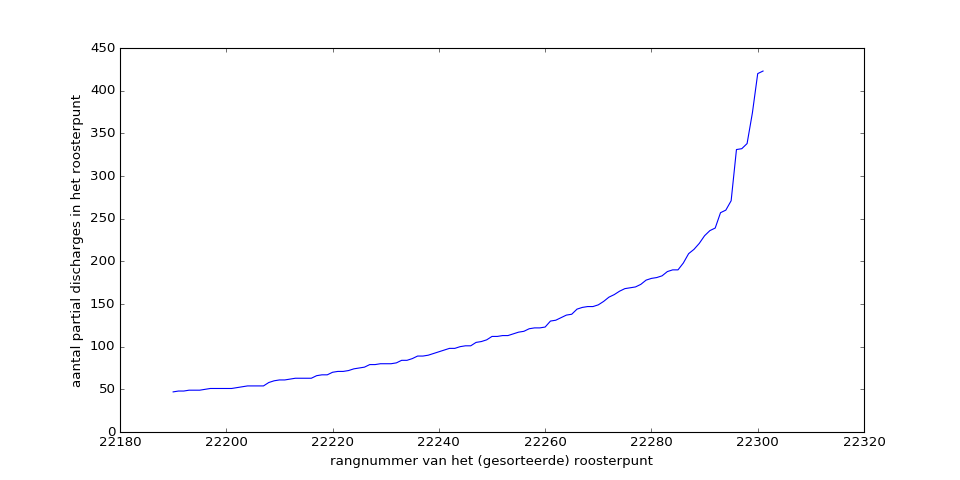

In [58]:
%matplotlib notebook
plot_boxes_sorted("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[2]+"-pd.csv")
plt.show()

Van een dataset waar niets mee aan de hand is:

<IPython.core.display.Javascript object>


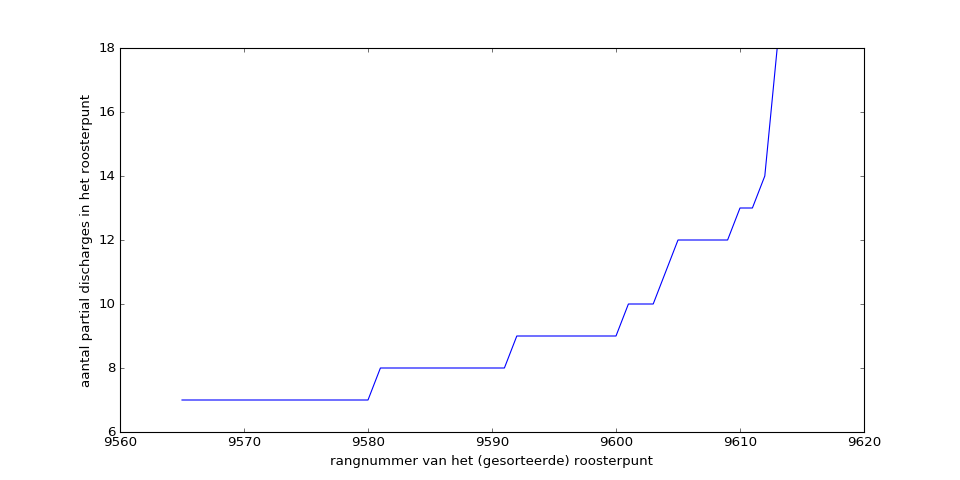

In [57]:
%matplotlib notebook
plot_boxes_sorted("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[-1]+"-pd.csv")
plt.show()

We zoeken een roosterpunt met een relatief hoog rangnummer, maar met een lage hoeveelheid partial discharges. We kunnen kijken naar het getal $N(x)-x$ waarbij $N(X)$ het aantal partial discharges is op het roosterpunt met rangnummer $x$. Als $x=0$ zal $N(x)-x$ ook de waarde 0 hebben, of een kleine positieve waarde als er in elk roosterpunt ten minste een partial discharge zit. Daarna wordt de waarde van $N(x)-x$ steeds kleiner, omdat $N(x)$ minder sterk toeneemt. Op een gegeven moment komen er meer partial discharges bij per rangnummer. Dit zorgt ervoor dat de waarde $N(x)-x$ juist gaat toenemen. Als dit gebeurt is de aanname dat er dan iets geks aan de hand is met de roosterpunten. We zoeken dus naar het rangnummer $y$ zodanig dat $N(y)-y=\min{\{N(x)-x\}}$, anders gezegd, de argmin van $N(x)-x$.

In [15]:
def plot_boxes_ratio(file,placeinterval=10,timeinterval=60*24*7,sensitivity=1):
    data=open_file(file)
    grid=make_pdgrid(data,placeinterval,timeinterval)
    grid=grid.flatten()
    grid=np.sort(grid)
    gridlength=len(grid)
    ratio=np.zeros(gridlength)
    for i in range(gridlength):
        ratio[i]=grid[i]-sensitivity*i
    minval=int(0.9*gridlength)
    ratio=ratio[minval:]
    plt.xlabel("rangnummer van het (gesorteerde) roosterpunt")
    plt.ylabel("f(x)")
    plt.plot(np.arange(minval,minval+len(ratio),1),ratio)

<IPython.core.display.Javascript object>


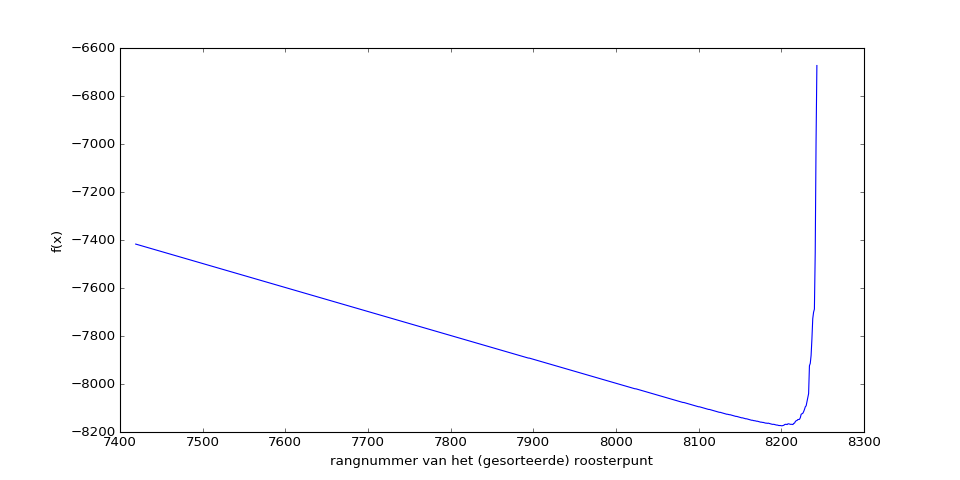

In [56]:
%matplotlib notebook
plot_boxes_ratio("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[1]+"-pd.csv")
plt.show()

<IPython.core.display.Javascript object>


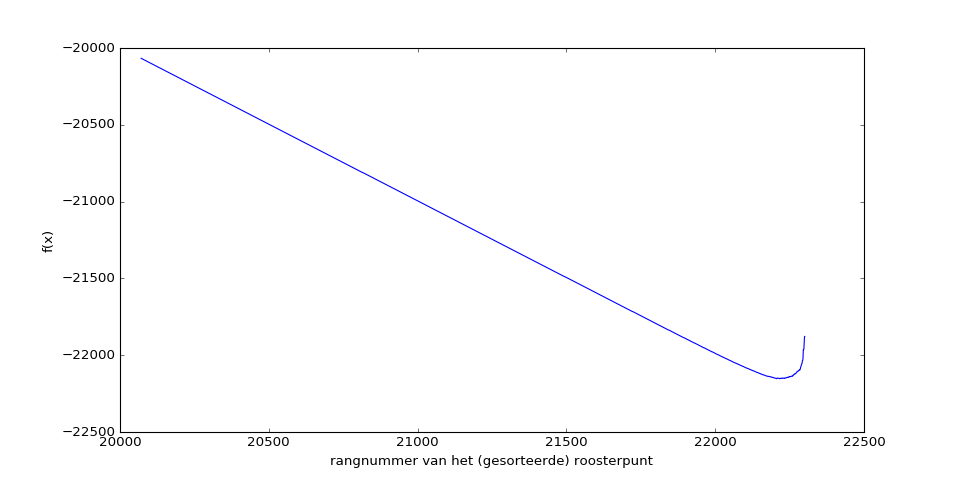

In [55]:
%matplotlib notebook
plot_boxes_ratio("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[2]+"-pd.csv")
plt.show()

<IPython.core.display.Javascript object>


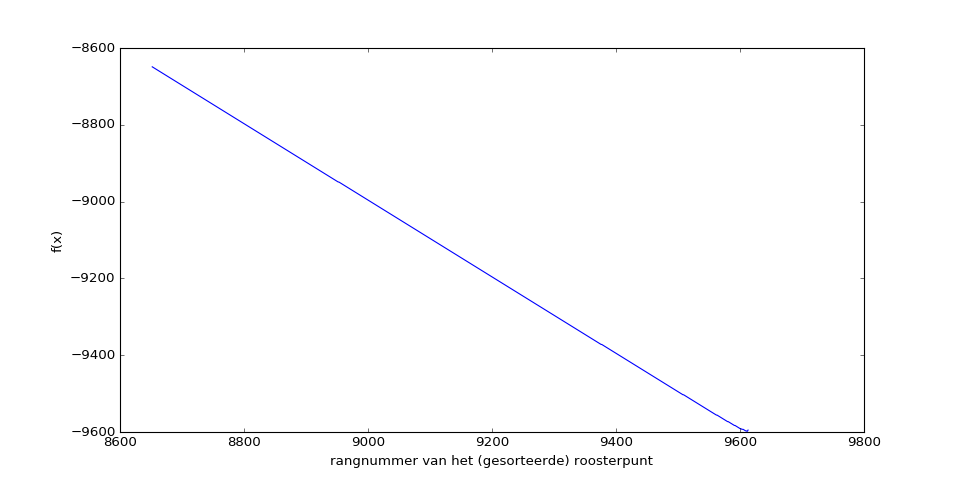

In [54]:
%matplotlib notebook
plot_boxes_ratio("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[-1]+"-pd.csv")
plt.show()

Het minimum is geplot in de grafieken:


In [19]:
def plot_boxes_sorted_ratio(file,placeinterval=10,timeinterval=60*24*7,sensitivity=1):
    data=open_file(file)
    grid=make_pdgrid(data,placeinterval,timeinterval)
    grid=grid.flatten()
    grid=np.sort(grid)
    gridlength=len(grid)
    ratio=np.zeros(gridlength)
    for i in range(gridlength):
        ratio[i]=grid[i]-sensitivity*i
    minx=np.argmin(ratio)
    minval=int(0.99*gridlength)
    grid=grid[minval:]
    plt.xlabel("rangnummer van het (gesorteerde) roosterpunt")
    plt.ylabel("aantal partial discharges in het roosterpunt")
    plt.axvline(x=minx,linewidth=4, color='r')
    plt.plot(np.arange(minval,minval+len(grid),1),grid)
    

<IPython.core.display.Javascript object>


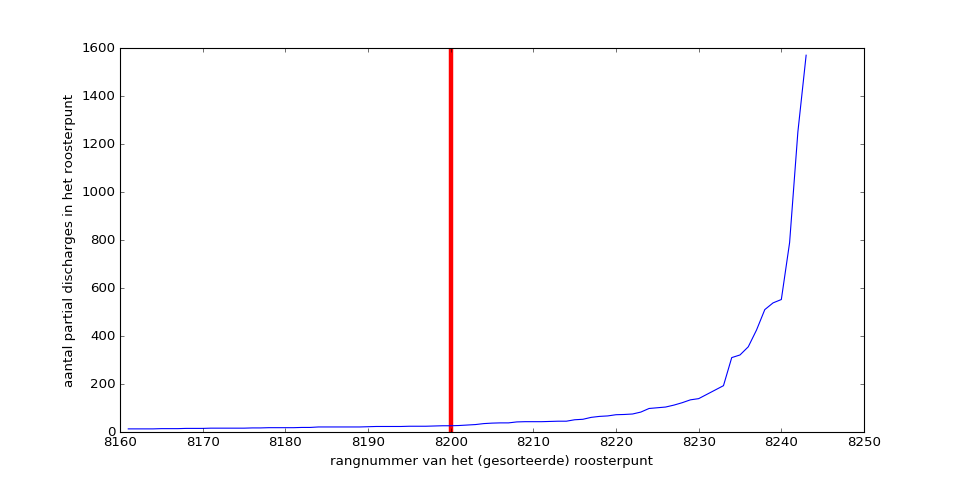

In [53]:
%matplotlib notebook
plot_boxes_sorted_ratio("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[1]+"-pd.csv")
plt.show()

<IPython.core.display.Javascript object>


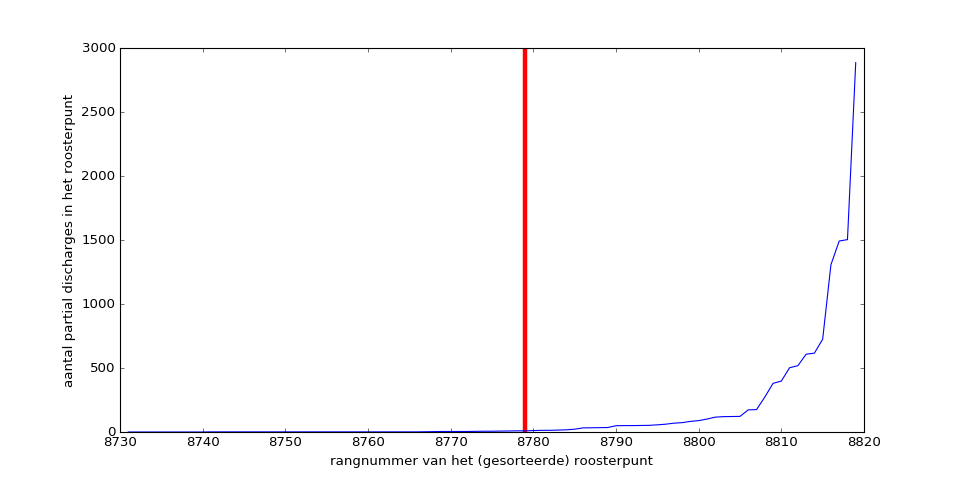

In [52]:
%matplotlib notebook
plot_boxes_sorted_ratio("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[3]+"-pd.csv")
plt.show()

<IPython.core.display.Javascript object>


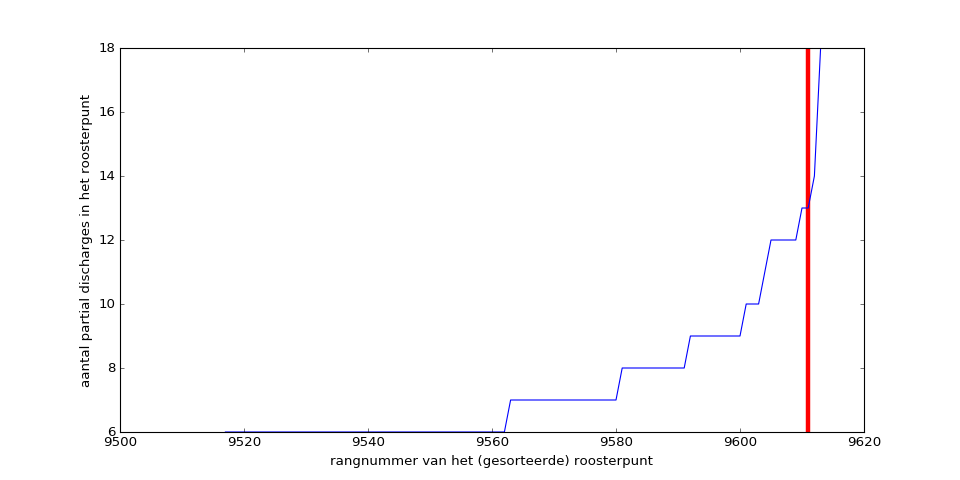

In [51]:
%matplotlib notebook
plot_boxes_sorted_ratio("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[-1]+"-pd.csv")
plt.show()

Dit kunnen we gebruiken voor het vinden van clusters:

In [23]:
def track_groups(elt,todo,ijlist):
    if elt in ijlist:
        todo+=[elt]
        ijlist.remove(elt)
def group_boxes(grid,condition,sizex,sizey):
    ijlist=[]
    for i in range(sizex):
        for j in range(sizey):
            if grid[i,j]>=condition:
                ijlist+=[[i,j]]
    groups=[]
    groupcount=0
    for ij in ijlist:
        groups+=[[ij]]
        groupstart=True
        todo=[ij]
        ijlist.remove(ij)
        while len(todo)>0:
            for p in todo:
                track_groups([p[0]+1,p[1]],todo,ijlist)
                track_groups([p[0]-1,p[1]],todo,ijlist)
                track_groups([p[0],p[1]+1],todo,ijlist)
                track_groups([p[0],p[1]-1],todo,ijlist)
                if groupstart==True:
                    groupstart=False
                else:
                    groups[groupcount]+=[p] 
                todo.remove(p)
        groupcount+=1
    return np.array(groups)

In [24]:
def show_clusters(file,placeinterval=10,timeinterval=7*24*60,sensitivity=1):
    
    #definities van variabelen
    
    data=open_file(file)
    datalength=len(data[0])
    maxplace=max(data[1])
    maxtime=max(data[0])

    #gewoon scatterplot

    plt.figure("plaatjen")
    plt.axis([0,maxplace,0,maxtime])
    plt.xlabel("Plaats")
    plt.ylabel("Tijd")
    plt.scatter(data[1],data[0],marker="o",s=1,c="black")

    #data discretiseren

    grid=make_pdgrid(data,placeinterval,timeinterval)
    
    #bepaal vanaf welke waarde er is "mis" is met een bakje
    
    Grid=grid
    Grid=Grid.flatten()
    Grid=np.sort(Grid)
    gridlength=len(Grid)
    ratio=np.zeros(gridlength)
    for i in range(gridlength):
        ratio[i]=Grid[i]-sensitivity*i
    minval=Grid[np.argmin(ratio)]
    
    #data groeperen

    groups=group_boxes(grid,minval,int(maxplace/placeinterval),int(maxtime/timeinterval))

    #plot tekenen
    
    colorcycle=["red","green","blue","yellow","orange","purple","pink","cyan","steelblue"]
    for i in range(len(groups)):
        for j in range(len(groups[i])):
            plt.gca().add_patch(Rectangle((groups[i][j][0]*placeinterval,groups[i][j][1]*timeinterval),placeinterval,timeinterval,linewidth=1,edgecolor=colorcycle[i%len(colorcycle)],facecolor=colorcycle[i%len(colorcycle)],alpha=0.5))

    plt.show()

<IPython.core.display.Javascript object>


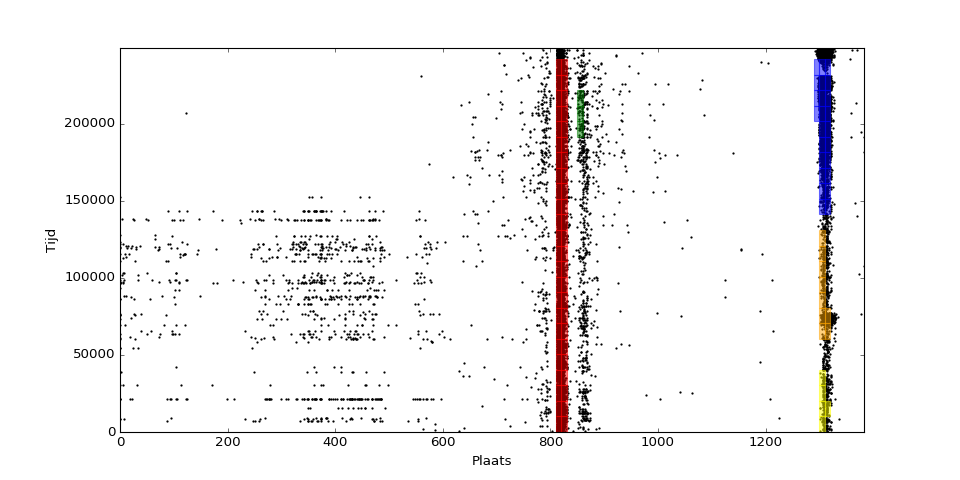

In [50]:
%matplotlib notebook
show_clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[0]+"-pd.csv")
plt.show()


<IPython.core.display.Javascript object>


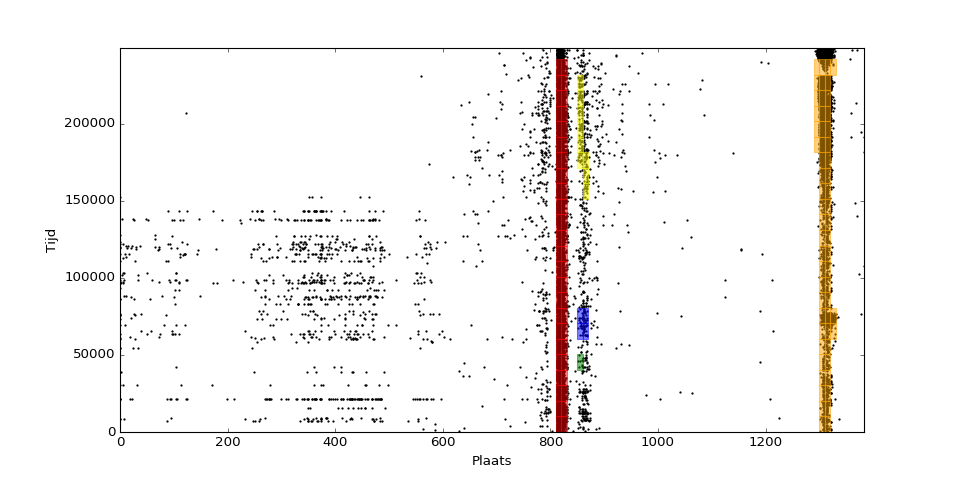

In [49]:
%matplotlib notebook
show_clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[0]+"-pd.csv",sensitivity=0.3)
plt.show()

<IPython.core.display.Javascript object>


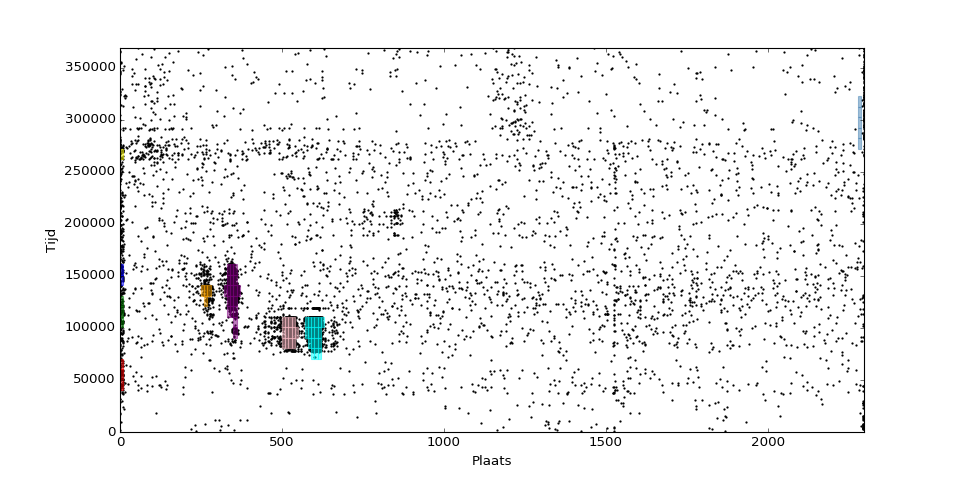

In [48]:
%matplotlib notebook
show_clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[1]+"-pd.csv",sensitivity=0.3)
plt.show()

<IPython.core.display.Javascript object>


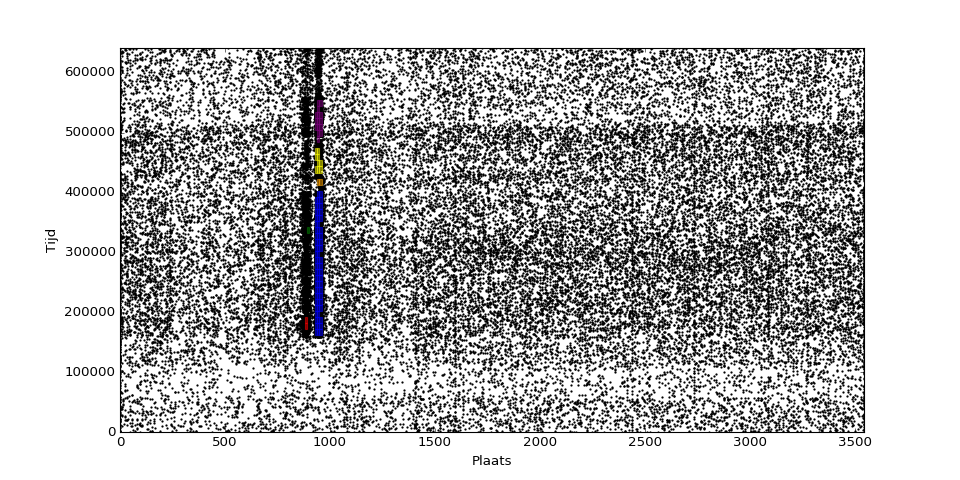

In [47]:
%matplotlib notebook
show_clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[2]+"-pd.csv")
plt.show()

<IPython.core.display.Javascript object>


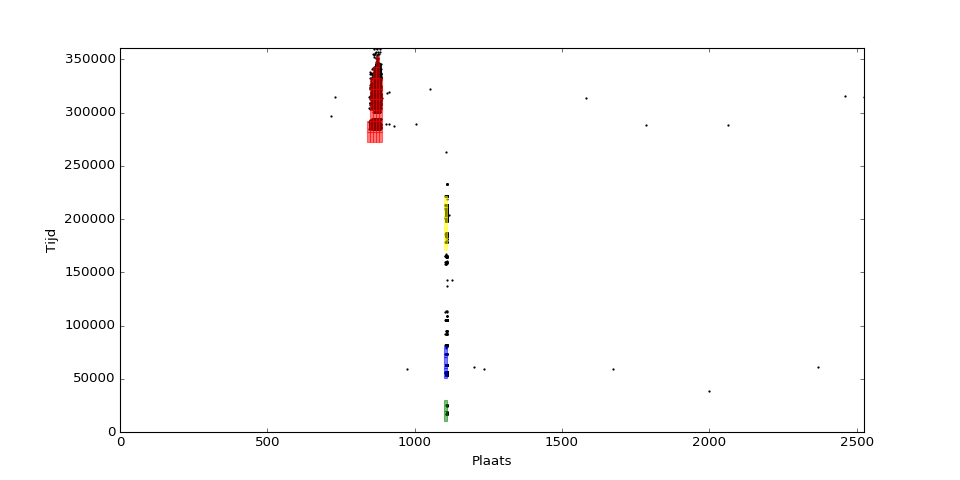

In [46]:
%matplotlib notebook
show_clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[3]+"-pd.csv")
plt.show()

<IPython.core.display.Javascript object>


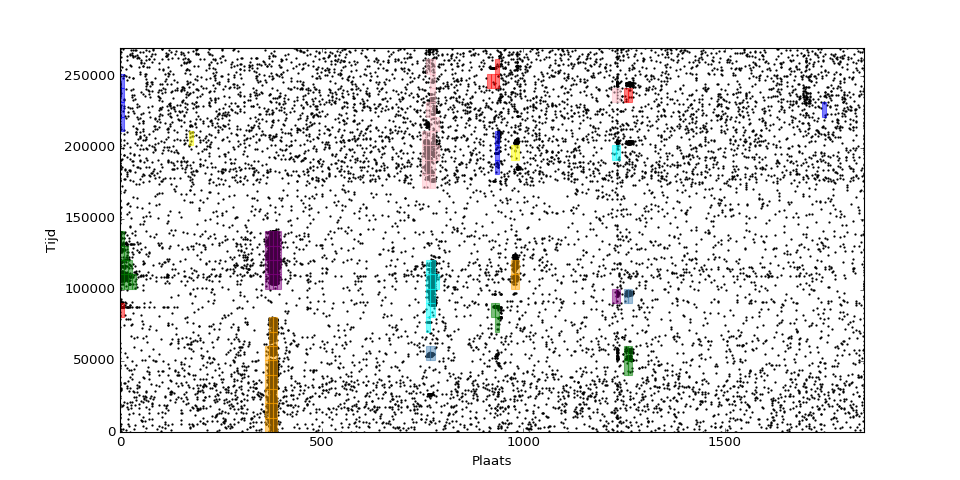

In [45]:
%matplotlib notebook
show_clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[4]+"-pd.csv",sensitivity=0.1)
plt.show()

<IPython.core.display.Javascript object>


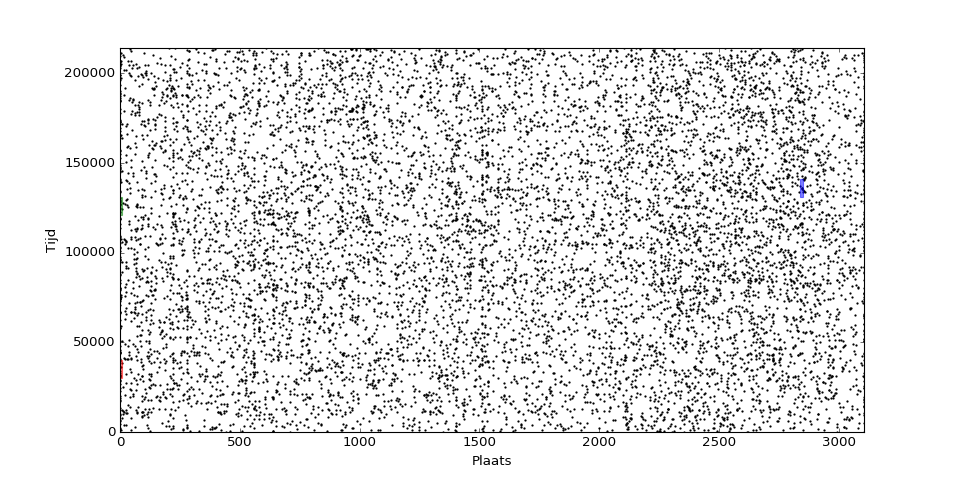

In [44]:
%matplotlib notebook
show_clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[5]+"-pd.csv")
plt.show()

<IPython.core.display.Javascript object>


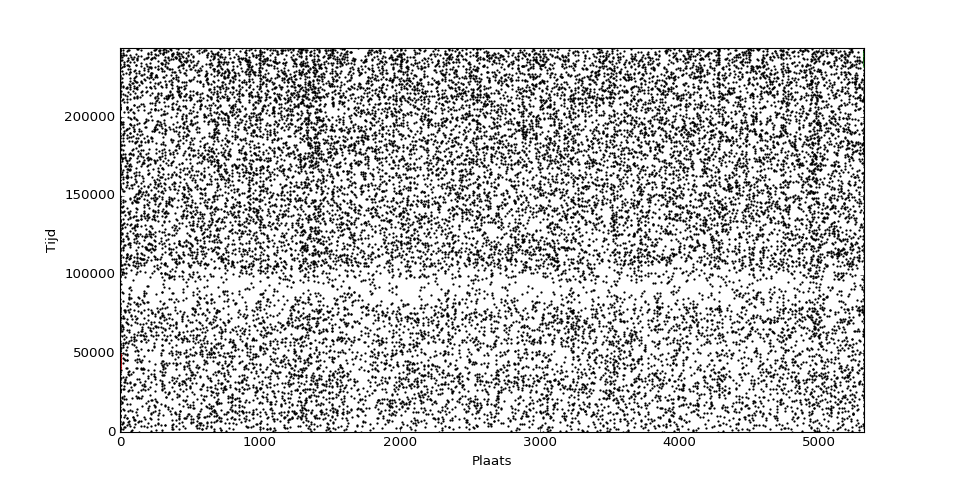

In [43]:
%matplotlib notebook
show_clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[6]+"-pd.csv")
plt.show()

<IPython.core.display.Javascript object>


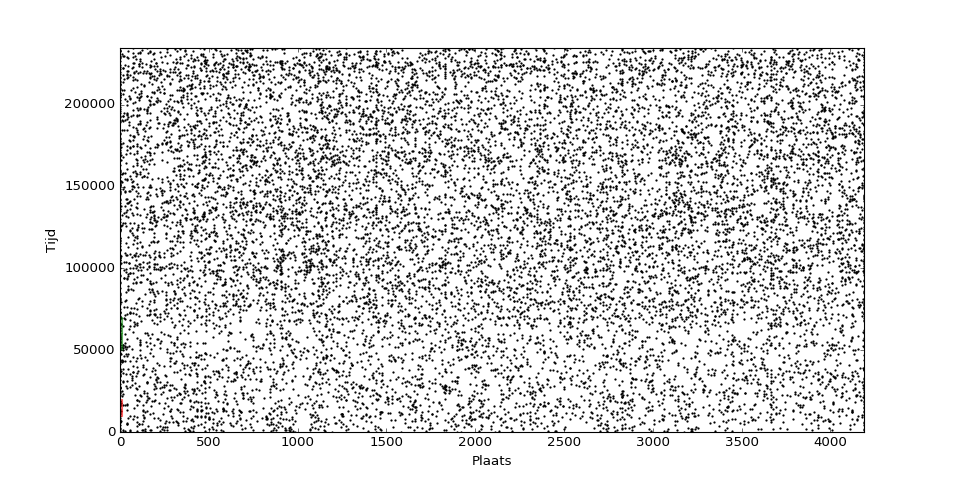

In [33]:
%matplotlib notebook
show_clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[7]+"-pd.csv")
plt.show()

Algoritme dat de clusters in een lijstje teruggeeft in plaats van een plot:

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
def clusters(file,placeinterval=10,timeinterval=7*24*60,sensitivity=1):
    #definities van variabelen
    
    data=open_file(file)
    datalength=len(data[0])
    maxplace=max(data[1])
    maxtime=max(data[0])

    #data discretiseren

    grid=make_pdgrid(data,placeinterval,timeinterval)
    
    #bepaal vanaf welke waarde er is "mis" is met een bakje
    
    Grid=grid
    Grid=Grid.flatten()
    Grid=np.sort(Grid)
    gridlength=len(Grid)
    ratio=np.zeros(gridlength)
    for i in range(gridlength):
        ratio[i]=Grid[i]-sensitivity*i
    minval=Grid[np.argmin(ratio)]
    
    #data groeperen

    groups=group_boxes(grid,minval,int(maxplace/placeinterval),int(maxtime/timeinterval))
    minp=np.zeros(len(groups))
    maxp=np.zeros(len(groups))
    mint=np.zeros(len(groups))
    maxt=np.zeros(len(groups))
    for i in range(len(groups)):
        minp[i]=maxplace
        maxp[i]=0
        mint[i]=maxtime
        maxt[i]=0
        for j in range(len(groups[i])):
            if groups[i][j][0]*placeinterval<minp[i]:
                minp[i]=groups[i][j][0]*placeinterval
            if (groups[i][j][0]+1)*placeinterval>maxp[i]:
                maxp[i]=(groups[i][j][0]+1)*placeinterval
            if groups[i][j][1]*timeinterval<mint[i]:
                mint[i]=groups[i][j][1]*timeinterval
            if (groups[i][j][1]+1)*timeinterval>maxt[i]:
                maxt[i]=(groups[i][j][1]+1)*timeinterval
        print("Cluster "+str(i+1)+": place interval: ["+str(minp[i])+","+str(maxp[i])+"], time interval: ["+str(mint[i])+","+str(maxt[i])+"]. ")
        

In [62]:
%%time
clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[0]+"-pd.csv")

Cluster 1: place interval: [810.0,830.0], time interval: [0.0,241920.0]. 
Cluster 2: place interval: [850.0,860.0], time interval: [191520.0,221760.0]. 
Cluster 3: place interval: [1290.0,1320.0], time interval: [141120.0,241920.0]. 
Cluster 4: place interval: [1300.0,1320.0], time interval: [0.0,40320.0]. 
Cluster 5: place interval: [1300.0,1320.0], time interval: [60480.0,131040.0]. 
CPU times: user 1.12 s, sys: 40 ms, total: 1.16 s
Wall time: 1.16 s


In [63]:
%%time
clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[1]+"-pd.csv")

Cluster 1: place interval: [0.0,10.0], time interval: [110880.0,120960.0]. 
Cluster 2: place interval: [330.0,370.0], time interval: [90720.0,161280.0]. 
Cluster 3: place interval: [500.0,540.0], time interval: [80640.0,110880.0]. 
Cluster 4: place interval: [570.0,620.0], time interval: [70560.0,110880.0]. 
CPU times: user 844 ms, sys: 52 ms, total: 896 ms
Wall time: 918 ms


In [70]:
%%time
clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[2]+"-pd.csv")

Cluster 1: place interval: [880.0,890.0], time interval: [171360.0,191520.0]. 
Cluster 2: place interval: [890.0,900.0], time interval: [332640.0,342720.0]. 
Cluster 3: place interval: [930.0,960.0], time interval: [161280.0,403200.0]. 
Cluster 4: place interval: [930.0,960.0], time interval: [433440.0,473760.0]. 
Cluster 5: place interval: [940.0,960.0], time interval: [413280.0,423360.0]. 
Cluster 6: place interval: [930.0,960.0], time interval: [483840.0,554400.0]. 
CPU times: user 3.7 s, sys: 80 ms, total: 3.78 s
Wall time: 3.78 s


In [65]:
%%time
clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[3]+"-pd.csv")

Cluster 1: place interval: [840.0,890.0], time interval: [272160.0,352800.0]. 
Cluster 2: place interval: [1100.0,1110.0], time interval: [10080.0,30240.0]. 
Cluster 3: place interval: [1100.0,1110.0], time interval: [50400.0,80640.0]. 
Cluster 4: place interval: [1100.0,1110.0], time interval: [171360.0,221760.0]. 
CPU times: user 796 ms, sys: 44 ms, total: 840 ms
Wall time: 835 ms


In [66]:
%%time
clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[4]+"-pd.csv")

Cluster 1: place interval: [0.0,20.0], time interval: [100800.0,141120.0]. 
Cluster 2: place interval: [360.0,400.0], time interval: [100800.0,141120.0]. 
Cluster 3: place interval: [370.0,390.0], time interval: [0.0,80640.0]. 
Cluster 4: place interval: [750.0,780.0], time interval: [171360.0,201600.0]. 
Cluster 5: place interval: [760.0,780.0], time interval: [80640.0,120960.0]. 
Cluster 6: place interval: [920.0,940.0], time interval: [80640.0,90720.0]. 
Cluster 7: place interval: [970.0,990.0], time interval: [191520.0,201600.0]. 
Cluster 8: place interval: [1220.0,1230.0], time interval: [90720.0,100800.0]. 
Cluster 9: place interval: [1220.0,1230.0], time interval: [231840.0,241920.0]. 
Cluster 10: place interval: [1250.0,1270.0], time interval: [90720.0,100800.0]. 
Cluster 11: place interval: [1250.0,1270.0], time interval: [50400.0,60480.0]. 
CPU times: user 1.44 s, sys: 32 ms, total: 1.48 s
Wall time: 1.47 s


In [67]:
%%time
clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[5]+"-pd.csv")

Cluster 1: place interval: [0.0,10.0], time interval: [30240.0,40320.0]. 
Cluster 2: place interval: [0.0,10.0], time interval: [120960.0,131040.0]. 
Cluster 3: place interval: [2840.0,2850.0], time interval: [131040.0,141120.0]. 
CPU times: user 556 ms, sys: 24 ms, total: 580 ms
Wall time: 578 ms


In [68]:
%%time
clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[6]+"-pd.csv")

Cluster 1: place interval: [0.0,10.0], time interval: [40320.0,50400.0]. 
Cluster 2: place interval: [5310.0,5320.0], time interval: [231840.0,241920.0]. 
CPU times: user 1.14 s, sys: 28 ms, total: 1.16 s
Wall time: 1.16 s


In [69]:
%%time
clusters("/home/geelhoed/GitHub/SCG-analyse/data/origineel/"+filelist[7]+"-pd.csv")

Cluster 1: place interval: [0.0,10.0], time interval: [10080.0,20160.0]. 
Cluster 2: place interval: [0.0,10.0], time interval: [50400.0,70560.0]. 
CPU times: user 752 ms, sys: 24 ms, total: 776 ms
Wall time: 780 ms
